In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/../Datasets")' Datasets
%install '.package(path: "$cwd/../Models")' Models

Installing packages:
	.package(path: "/home/cheems/Workspace/s4tf-benchmark/Notebooks/../Datasets")
		Datasets
	.package(path: "/home/cheems/Workspace/s4tf-benchmark/Notebooks/../Models")
		Models
With SwiftPM flags: []
Working in: /tmp/tmp3utze1b4/swift-install
[1/3] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/4] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!
2021-01-03 00:20:54.929289: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import TensorFlow 

import Datasets
import Models

## Download MNIST dataset

In [3]:
let remoteBaseDirectory = "https://storage.googleapis.com/cvdf-datasets/mnist/"
let localBaseDirectory = "../data/mnist/"

let filenames = [
    "train-images-idx3-ubyte",
    "train-labels-idx1-ubyte",
    "t10k-images-idx3-ubyte",
    "t10k-labels-idx1-ubyte"
]

for filename in filenames {
    downloadDataset(
        file: filename,
        from: remoteBaseDirectory,
        to: localBaseDirectory)
}

/home/cheems/Workspace/s4tf-benchmark/data/mnist/train-images-idx3-ubyte already downloaded.
/home/cheems/Workspace/s4tf-benchmark/data/mnist/train-labels-idx1-ubyte already downloaded.
/home/cheems/Workspace/s4tf-benchmark/data/mnist/t10k-images-idx3-ubyte already downloaded.
/home/cheems/Workspace/s4tf-benchmark/data/mnist/t10k-labels-idx1-ubyte already downloaded.


## Load dataset as TrainingEpochs

In [4]:
let trainingImages: Tensor<Float> = loadMNISTDataset(from: localBaseDirectory + filenames[0], 
                                                     isTraining: true, isLabel: false, toFlatten: true) / 255.0
let trainingLabels: Tensor<Int32> = loadMNISTDataset(from: localBaseDirectory + filenames[1],
                                                     isTraining: true, isLabel: true, toFlatten: true)

2021-01-03 00:20:58.476179: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-01-03 00:20:58.511263: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3593210000 Hz
2021-01-03 00:20:58.512226: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3241d80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-01-03 00:20:58.512250: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-01-03 00:20:58.536427: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-01-03 00:20:58.540839: I tensorflow/stream_executor/cuda/

In [5]:
let batchSize = 32


public struct MNISTBatch {
    let images: Tensor<Float>
    let labels: Tensor<Int32>
}

extension MNISTBatch : Collatable {
    public init<BatchSamples: Collection>(collating samples: BatchSamples) 
        where BatchSamples.Element == Self {
            images = Tensor<Float>(stacking: samples.map{$0.images})
            labels = Tensor<Int32>(stacking: samples.map{$0.labels})
        }
}

let trainingDataset: [MNISTBatch] = zip(trainingImages.unstacked(), trainingLabels.unstacked()).map{MNISTBatch(images: $0.0, labels: $0.1)}
let trainingEpochs: TrainingEpochs = TrainingEpochs(samples: trainingDataset, batchSize: batchSize)

In [6]:
let firstEpoch = trainingEpochs.next()!
let firstTrainBatch = firstEpoch.first!.collated
let firstBatchImages = firstTrainBatch.images
let firstBatchLabels = firstTrainBatch.labels

print("First batch of features: \(firstBatchImages)")
print("firstTrainFeatures.shape: \(firstBatchImages.shape)")
print("First batch of labels: \(firstBatchLabels)")
print("firstTrainLabels.shape: \(firstBatchLabels.shape)")

First batch of features: [[        0.0,         0.0,         0.0, ...,         0.0,         0.0,         0.0],
 [        0.0,         0.0,         0.0, ...,         0.0,         0.0,         0.0],
 [        0.0,         0.0,         0.0, ...,         0.0,         0.0,         0.0],
 ...,
 [        0.0,         0.0,         0.0, ...,         0.0,         0.0,         0.0],
 [        0.0,         0.0,         0.0, ...,         0.0,         0.0,         0.0],
 [        0.0,         0.0,         0.0, ...,         0.0,         0.0,         0.0]]
firstTrainFeatures.shape: [32, 784]
First batch of labels: [7, 4, 8, 6, 6, 1, 8, 5, 5, 5, 2, 3, 4, 6, 4, 7, 5, 2, 5, 7, 1, 2, 5, 0, 5, 5, 6, 9, 7, 0, 2, 3]
firstTrainLabels.shape: [32]


## Define Model and Optimizer

In [7]:
var model = DenseModel()
let optimizer = SGD(for: model, learningRate: 0.01)

## Training Loop

In [8]:
func accuracy (predictions logits: Tensor<Float>, truths batchLabels: Tensor<Int32>) -> Float {
    return Tensor<Float>(logits.argmax(squeezingAxis: 1) .== batchLabels).mean().scalarized()
}

In [9]:
let epochCount = 500
var trainAccuracyResults = [Float]()
var trainLossResults = [Float]()

for (epochIndex, epoch) in trainingEpochs.prefix(epochCount).enumerated() {
    var epochLoss: Float = 0
    var epochAccuracy: Float = 0
    var batchCount: Int = 0
    for batchSamples in epoch {
        let batch = batchSamples.collated
        let (loss, grad) = valueWithGradient(at: model) { (model: DenseModel) -> Tensor<Float> in
            let logits = model(batch.images)
            return softmaxCrossEntropy(logits: logits, labels: batch.labels)
        }
        optimizer.update(&model, along: grad)

        let logits = model(batch.images)
        epochAccuracy += accuracy(predictions: logits, truths: batch.labels)
        epochLoss += loss.scalarized()
        batchCount += 1
    }
    epochAccuracy /= Float(batchCount)
    epochLoss /= Float(batchCount)
    trainAccuracyResults.append(epochAccuracy)
    trainLossResults.append(epochLoss)
    if epochIndex % 50 == 0 {
        print("Epoch \(epochIndex): Loss: \(epochLoss), Accuracy: \(epochAccuracy)")
    }
}

Epoch 0: Loss: 1.0215597, Accuracy: 0.6866
Epoch 50: Loss: 0.17279756, Accuracy: 0.9647667
Epoch 100: Loss: 0.15253778, Accuracy: 0.97083336
Epoch 150: Loss: 0.14034134, Accuracy: 0.97405
Epoch 200: Loss: 0.13151322, Accuracy: 0.9759
Epoch 250: Loss: 0.12564613, Accuracy: 0.9769667
Epoch 300: Loss: 0.120738275, Accuracy: 0.97851664
Epoch 350: Loss: 0.11700909, Accuracy: 0.9792333
Epoch 400: Loss: 0.11517548, Accuracy: 0.9799
Epoch 450: Loss: 0.11192699, Accuracy: 0.9808


## Visualize Loss and Accuracy

In [11]:
import PythonKit

%include "EnableIPythonDisplay.swift"
print(IPythonDisplay.shell.enable_matplotlib("inline"))

('inline', 'module://ipykernel.pylab.backend_inline')


In [12]:
let plt = Python.import("matplotlib.pyplot")

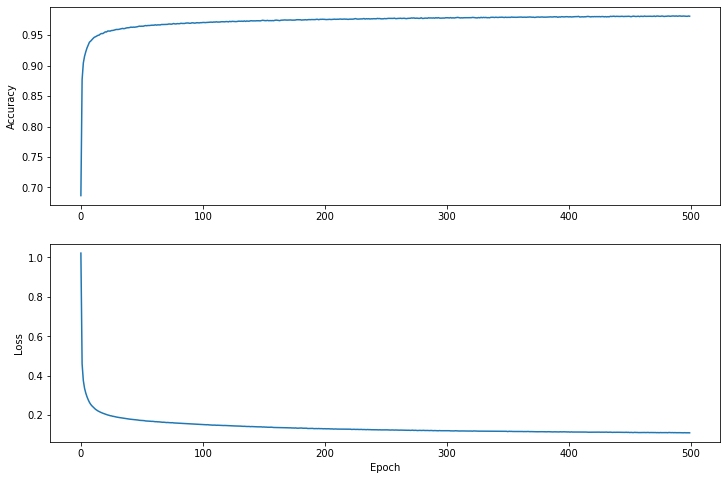

Use `print()` to show values.


In [13]:
plt.figure(figsize: [12, 8])

let accuracyAxes = plt.subplot(2, 1, 1)
accuracyAxes.set_ylabel("Accuracy")
accuracyAxes.plot(trainAccuracyResults)

let lossAxes = plt.subplot(2, 1, 2)
lossAxes.set_ylabel("Loss")
lossAxes.set_xlabel("Epoch")
lossAxes.plot(trainLossResults)

plt.show()